In [18]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape

In [19]:
FIGSIZE = (20, 6)

location = "A801"
idx = "datetime"
target = "global-radiation"
by_day_rolling = pd.read_csv(f"by_day_rolling_{location}.csv")
by_day_rolling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8595 entries, 0 to 8594
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   datetime                   8595 non-null   object 
 1   global-radiation           8568 non-null   float64
 2   total-precipitation        8540 non-null   float64
 3   relative-humidity          8568 non-null   float64
 4   temperature-last-hour-max  8512 non-null   float64
 5   temperature-last-hour-min  8512 non-null   float64
 6   wind-speed                 8430 non-null   float64
 7   wind-speed-max-gust        8346 non-null   float64
dtypes: float64(7), object(1)
memory usage: 537.3+ KB


In [20]:
by_day_rolling[idx] = by_day_rolling[idx].apply(
    lambda d: pd.to_datetime(d, format="%Y-%m-%d")
)
by_day_rolling = by_day_rolling.set_index(idx)
by_day_rolling.tail()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2024-07-27,713.967357,0.074702,81.117560,13.881845,13.056399,1.104911,3.698810
2024-07-28,678.630019,0.081845,82.308036,14.147470,13.340476,1.082738,3.649405
2024-07-29,647.905993,0.109821,82.985119,14.268601,13.486905,1.103571,3.778423
2024-07-30,653.105344,0.109821,83.172619,14.280208,13.523065,1.146280,3.925893
2024-07-31,681.701872,0.109821,83.013393,14.323958,13.558631,1.159673,3.960417


'train len = 8019'

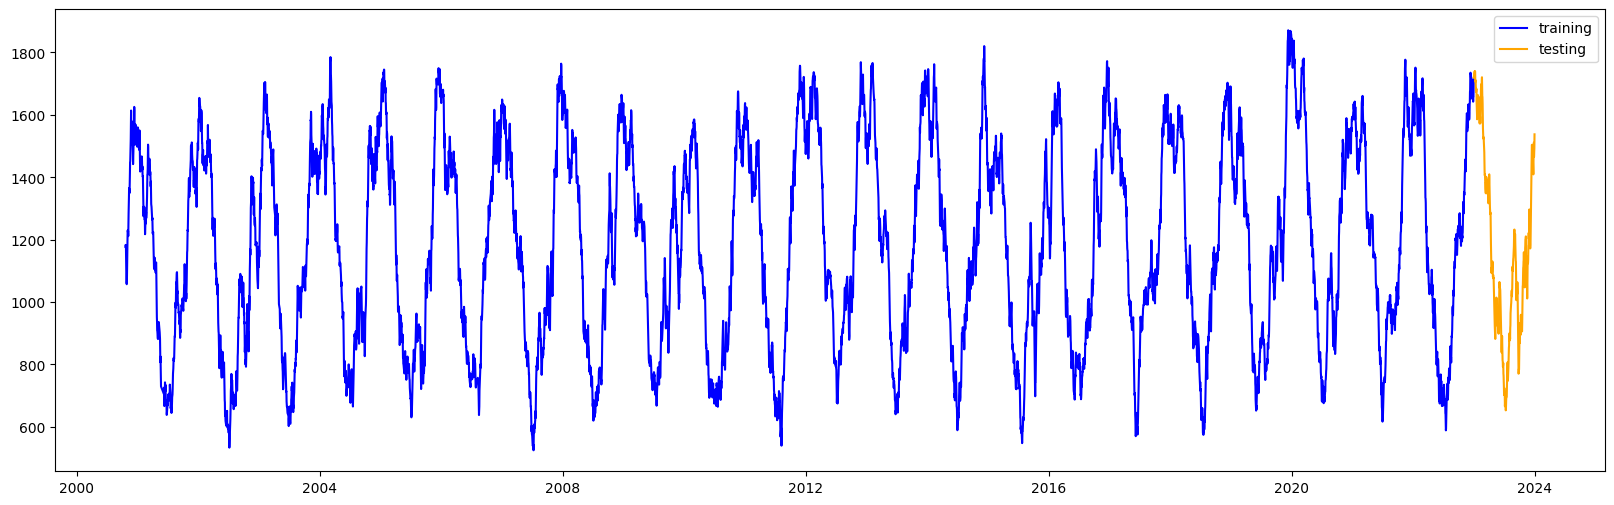

In [21]:
date_threshold = pd.to_datetime("2023-01-01", format="%Y-%m-%d")
date_upper_threshold = date_threshold + pd.DateOffset(years=1)


def training_threshold(col):
    return col <= date_threshold


def testing_treshold(col):
    return (col >= date_threshold) & (col <= date_upper_threshold)


def split_datasets(df):
    return (
        df[training_threshold(df.index)],  # .dropna(),
        df[testing_treshold(df.index)],  # .dropna(),
    )


train_rolling, test_rolling = split_datasets(by_day_rolling)

plt.figure(figsize=FIGSIZE)
plt.plot(train_rolling[target], color="blue", label="training")
plt.plot(test_rolling[target], color="orange", label="testing")
plt.legend()

f"train len = {train_rolling[target].size}"

In [22]:
xgb_df = by_day_rolling.copy()
xgb_df["lag1"] = (xgb_df.index - pd.DateOffset(years=1)).map(
    train_rolling[target].to_dict()
)
xgb_df.index - pd.DateOffset(years=1)
xgb_df["lag2"] = (xgb_df.index - pd.DateOffset(years=2)).map(
    train_rolling[target].to_dict()
)
xgb_df["lag3"] = (xgb_df.index - pd.DateOffset(years=3)).map(
    train_rolling[target].to_dict()
)
xgb_df["lag4"] = (xgb_df.index - pd.DateOffset(years=4)).map(
    train_rolling[target].to_dict()
)
# xgb_df["lag_history"] = xgb_df.index.day_of_year.map(all_years[target].to_dict())

xgb_df["date"] = xgb_df.index

xgb_df["doy"] = xgb_df["date"].apply(lambda d: d.day_of_year)
xgb_df["woy"] = xgb_df["date"].apply(lambda d: d.date().isocalendar()[1])
xgb_df["month"] = xgb_df["date"].apply(lambda d: d.month)

xgb_df.tail()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust,lag1,lag2,lag3,lag4,date,doy,woy,month
datetime,,,,,,,,,,,,,,,
2024-07-27,713.967357,0.074702,81.117560,13.881845,13.056399,1.104911,3.698810,NaN,739.068427,924.177300,778.951314,2024-07-27,209,30,7
2024-07-28,678.630019,0.081845,82.308036,14.147470,13.340476,1.082738,3.649405,NaN,709.793427,944.176326,785.543522,2024-07-28,210,30,7
2024-07-29,647.905993,0.109821,82.985119,14.268601,13.486905,1.103571,3.778423,NaN,687.178947,951.541261,821.169346,2024-07-29,211,31,7
2024-07-30,653.105344,0.109821,83.172619,14.280208,13.523065,1.146280,3.925893,NaN,702.764336,957.863014,834.762528,2024-07-30,212,31,7
2024-07-31,681.701872,0.109821,83.013393,14.323958,13.558631,1.159673,3.960417,NaN,735.726674,966.044183,840.710905,2024-07-31,213,31,7


In [23]:
feats = ["doy", "woy", *[c for c in xgb_df.columns if "lag" in c]]
# for c in xgb_df.columns:
#     if c == target:
#         continue
#     if abs(xgb_df.corr()[target][c]) >= 0.5:
#         feats.append(c)
print(feats)

xgb_train = xgb_df.loc[training_threshold(xgb_df.index)]
xgb_test = xgb_df.loc[testing_treshold(xgb_df.index)]


def split_x_y_xgb(df, feats, target):
    return df.loc[df[target].notna(), feats], df.loc[df[target].notna(), target]


X_train, y_train = split_x_y_xgb(xgb_train, feats, target)
X_test, y_test = split_x_y_xgb(xgb_test, feats, target)

reg = xgb.XGBRegressor(
    base_score=1.0,
    booster="gbtree",
    n_estimators=1000,
    early_stopping_rounds=500,
    objective="reg:squarederror",
    max_depth=3,
    learning_rate=0.1,
)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

['doy', 'woy', 'lag1', 'lag2', 'lag3', 'lag4']
[0]	validation_0-rmse:1105.45136	validation_1-rmse:1086.60780
[100]	validation_0-rmse:102.37908	validation_1-rmse:153.28563
[200]	validation_0-rmse:93.22184	validation_1-rmse:150.04836
[300]	validation_0-rmse:87.01233	validation_1-rmse:150.47245
[400]	validation_0-rmse:82.02406	validation_1-rmse:151.09714
[500]	validation_0-rmse:78.36205	validation_1-rmse:151.30311
[600]	validation_0-rmse:75.17441	validation_1-rmse:152.51558
[658]	validation_0-rmse:73.56678	validation_1-rmse:152.49220


XGBRegressor(base_score=1.0, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=500,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: >

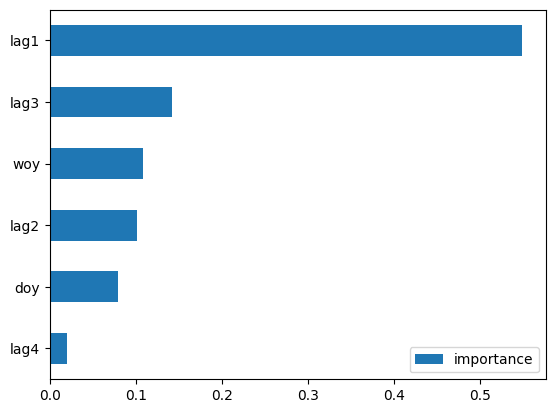

In [24]:
feature_importance = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"]
).sort_values("importance")

feature_importance.plot(kind="barh")

In [26]:
xgb_prediction = reg.predict(X_test)

prediction = pd.DataFrame(
    data=xgb_prediction, index=X_test.index, columns=["prediction"]
)
prediction = prediction.merge(
    test_rolling.loc[testing_treshold(test_rolling.index), target],
    left_index=True,
    right_index=True,
)

'xgb error = 0.1059%'

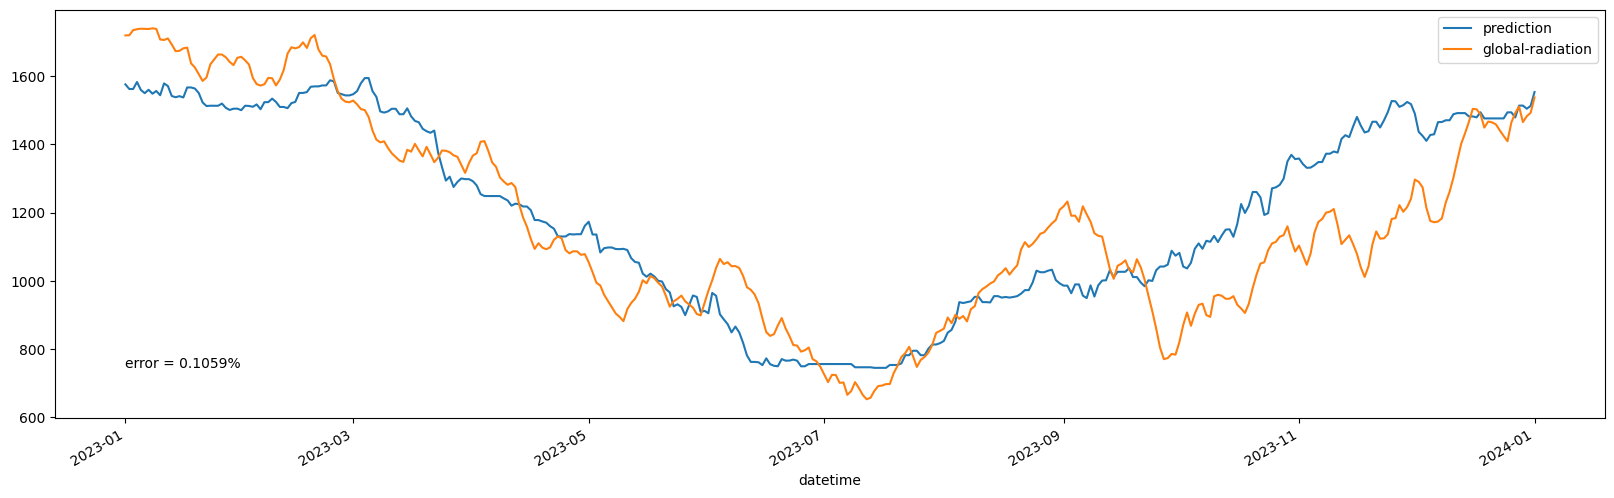

In [31]:
xgb_error = mape(prediction[target], prediction.prediction)
ax = prediction.plot(figsize=FIGSIZE)
ax.text(
    prediction.index.min(), prediction.prediction.min(), f"error = {xgb_error:.4f}%"
)

f"xgb error = {xgb_error:.4f}%"